<span style='font-size:18.0pt'> Video Stream Object Detection and Classification Latency </span>

<span style='font-size:18.0pt'> AWS m6g Graviton 2 (48 vCPU) </span>

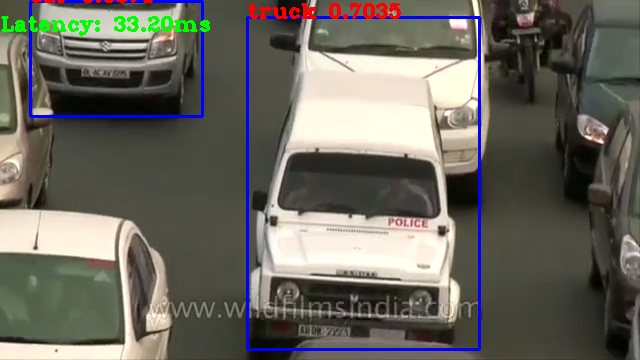

Version: latest-1043-g773bbcaa0
git-773bbcaa0,jerrybdev,2021-09-10T14:12:30+02:00 built 20210914_175124 by  on  development-1
Attempt to register kernel  AvgPoolingMeta<FP16[8]>@NEON with priority clashes (priority-wise) with the following kernels:  AvgPoolingMeta<FLOAT[4]>@NEON AvgPoolingMeta<INT8[32]>@NEON 
Attempt to register kernel  MaxPoolingMeta<FP16[8]>@NEON with priority clashes (priority-wise) with the following kernels:  MaxPoolingMeta<FLOAT[4]>@NEON MaxPoolingMeta<INT8[16]>@NEON 
Unknown DLS variable: DLS_ARM64 = "1"
AVX512_ENABLED: 0
DLS_PROCESS_MODE:  0
DLS_NUM_THREADS:  48
CPU_BIND:  1
MEM_BIND:  1
DLS_SUPERNODE 0


In [ ]:
import time
import sys
import math
import cv2
import numpy as np
import tensorflow as tf
from labels import coco_labels

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from IPython.display import clear_output, Image, display, HTML, Markdown

def printmd(string):
    display(Markdown(string))

num_classes = 90
num_threads = 48
img_size = 320
vid = cv2.VideoCapture('input_video.mp4')

def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    #boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    boxes, objectness, classes, nums = np.squeeze(boxes), np.squeeze(objectness), np.squeeze(classes), np.squeeze(nums)
    hw = img.shape[0:2]
    for i in range(int(nums)):    
        if objectness[i] < 0.55:
            continue
        ymin, xmin = (boxes[i][0:2] * hw).astype(np.int32)
        ymax, xmax = (boxes[i][2:4] * hw).astype(np.int32)
        x1y1 = xmin, ymin
        x2y2 = xmax, ymax
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img

    
config = tf.compat.v1.ConfigProto()
config.allow_soft_placement = True
config.intra_op_parallelism_threads = num_threads
config.inter_op_parallelism_threads = 1
    
graph = tf.compat.v1.Graph()
with graph.as_default():
    graph_def = tf.compat.v1.GraphDef()
    with tf.compat.v1.gfile.GFile('./ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb', 'rb') as fid:
        serialized_graph = fid.read()
        graph_def.ParseFromString(serialized_graph)
        tf.compat.v1.import_graph_def(graph_def, name="")
    sess = tf.compat.v1.Session(config=config, graph=graph)
    
input_names = ["image_tensor"]
output_names = ["detection_classes", "detection_boxes", "detection_scores", "num_detections"]
    
# Input tensor is the image
image_tensor = graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = graph.get_tensor_by_name('detection_scores:0')
detection_classes = graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = graph.get_tensor_by_name('num_detections:0')

times = []

printmd("<span style='font-size:18.0pt'> Video Stream Object Detection and Classification Latency </span>")
printmd("<span style='font-size:18.0pt'> AWS m6g Graviton 2 ({} vCPU) </span>".format(num_threads))

display_handle = display(None, display_id=True)
frames = 0
     
try:
    while True: 
        _, img = vid.read()
        if img is None:
            vid.set(cv2.CAP_PROP_POS_FRAMES, 0)
            continue
            
        if img.size == 0:
            vid.set(cv2.CAP_PROP_POS_FRAMES, 0)
            continue
        
        img_in = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_in = cv2.resize(img_in, (img_size, img_size)).astype("float32") 
        
        img_in = img_in[:img_size, :img_size]
        img_in = img_in[np.newaxis, :, :, :]
        
        t1 = time.time()
        (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: img_in})
        t2 = time.time()
        times.append(t2-t1)
        times = times[-20:]
        img = draw_outputs(img, (boxes, scores, classes, num), coco_labels)

        
        latency = sum(times)/len(times) * 1000
        img = cv2.putText(img, "Latency: {:.2f}ms".format(latency), (0, 30),
                cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0), 2)
        _, img = cv2.imencode('.jpeg', img)
      
        display_handle.update(Image(data=img.tobytes()))
        frames = frames + 1
except KeyboardInterrupt:
    pass
finally:
    vid.release()
    display_handle.update(None)
    
